In [1]:
#importing the necessary dependencies
import os
from layers import Fixations
try:
    from urllib.request import urlretrieve
except:
    from urllib import urlretrieve
from utils import *

BACKEND = 'tf'
if BACKEND=='tf':
    from tf_helpers import Net, Data
else: 
    from caffe.proto import caffe_pb2
    import caffe

%matplotlib inline

In [2]:
#initializing the model

if BACKEND == 'tf':
    model_path = os.path.join('../models', 'vgg_16', 'vgg16.ckpt.data-00000-of-00001')
    index_path = os.path.join('../models', 'vgg_16', 'vgg16.ckpt.index')
    graph_path = os.path.join('../models', 'vgg_16', 'vgg16.ckpt.meta')
    checkpoint_path = os.path.join('../models', 'vgg_16', 'checkpoint')
    if not os.path.isfile(model_path):
    # currently downloading google drive files through urlretrieve does not work, please download them manually
        print('Downloading VGG-16 weights...')
        urlretrieve ('https://drive.google.com/file/d/0B7_JBKQvp2qbUXhpZWl6eTd4eEk/view?usp=sharing', model_path)
        urlretrieve ('https://drive.google.com/file/d/0B7_JBKQvp2qbTU9JbW82OWJhMEk/view?usp=sharing', checkpoint_path)
        urlretrieve ('https://drive.google.com/file/d/0B7_JBKQvp2qbS1JZMDdyNkNZODQ/view?usp=sharing', graph_path)
        urlretrieve ('https://drive.google.com/file/d/0B7_JBKQvp2qbbFZ4SHprSGtESDA/view?usp=sharing', index_path)
    
    net = Net('../models/vgg_16/vgg16.ckpt.meta', '../models/vgg_16/vgg16.ckpt')
        
else:
    # Specifying to use the GPU
    caffe.set_mode_gpu()
    caffe.set_device(0)

    model_path = os.path.join('../models', 'vgg_16', 'VGG_ILSVRC_16_layers.caffemodel')
    if not os.path.isfile(model_path):
        print('Downloading VGG-16 weights...')
        urlretrieve ("http://www.robots.ox.ac.uk/~vgg/software/very_deep/caffe/VGG_ILSVRC_16_layers.caffemodel", model_path)

    net = caffe.Classifier('../models/vgg_16/deploy.prototxt', model_path, channel_swap=(2,1,0))

layers = Fixations(net)

INFO:tensorflow:Restoring parameters from ../models/vgg_16/vgg16.ckpt
Activation Not Found.


In [3]:
def vgg(points, inc, resFac):
    if BACKEND == 'tf':
        points = layers.fc(points=points, layer='fc3', prevLayer='fc2')
        points = layers.fc(points=points, layer='fc2', prevLayer='fc1')
        points = layers.fc(points=points, layer='fc1', prevLayer='pool4_1')
    else:
        points = layers.fc(points=points, layer='fc8', prevLayer='fc7')
        points = layers.fc(points=points, layer='fc7', prevLayer='fc6')
        points = layers.fc(points=points, layer='fc6', prevLayer='pool5')
        
    points = layers.pool(points=points, prevLayer='conv5_3', K=2, S=2)
    points = layers.conv(points=points,  layer='conv5_3', prevLayer='conv5_2', K=3, S=1, P=1)
    points = layers.conv(points=points,  layer='conv5_2', prevLayer='conv5_1', K=3, S=1, P=1)
    points = layers.conv(points=points,  layer='conv5_1', prevLayer='pool4', K=3, S=1, P=1)
    points = layers.pool(points=points, prevLayer='conv4_3', K=2, S=2)
    points = layers.conv(points=points,  layer='conv4_3', prevLayer='conv4_2', K=3, S=1, P=1)
    points = layers.conv(points=points,  layer='conv4_2', prevLayer='conv4_1', K=3, S=1, P=1)
    points = layers.conv(points=points,  layer='conv4_1', prevLayer='pool3', K=3, S=1, P=1)
    points = layers.pool(points=points, prevLayer='conv3_3', K=2, S=2)
    points = layers.conv(points=points,  layer='conv3_3', prevLayer='conv3_2', K=3, S=1, P=1)
    points = layers.conv(points=points,  layer='conv3_2', prevLayer='conv3_1', K=3, S=1, P=1)
    points = layers.conv(points=points,  layer='conv3_1', prevLayer='pool2', K=3, S=1, P=1)
    points = layers.pool(points=points, prevLayer='conv2_2', K=2, S=2)
    points = layers.conv(points=points,  layer='conv2_2', prevLayer='conv2_1', K=3, S=1, P=1)
    points = layers.conv(points=points,  layer='conv2_1', prevLayer='pool1', K=3, S=1, P=1)
    points = layers.pool(points=points, prevLayer='conv1_2', K=2, S=2)
    points = layers.data(points=points, inc=inc, resFac=resFac)
    return points

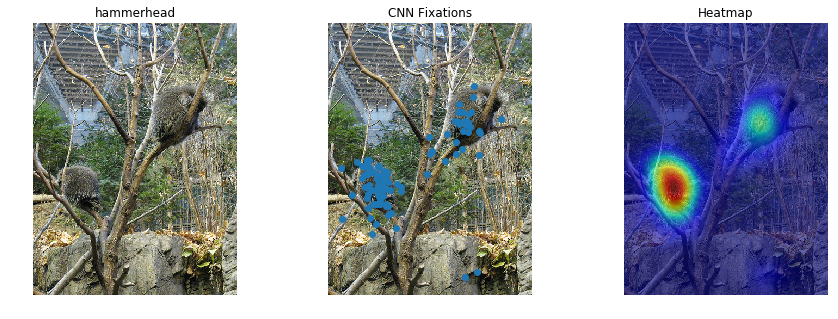

In [4]:
img_path = 'sample.jpg'
img, offset, resFac, newSize = imgPreprocess(img_path=img_path)
net.image_dims = newSize
points, image_label = pred(net, img)
points = vgg(points, offset, resFac)
visualize(img_path, points, diag_percent=0.1, image_label=image_label)